# RegularizationAndDropout(Keras)

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Input,Dense,Dropout
from get_data_set import load_data
from Plot_Plot import plot_plot

Using TensorFlow backend.


In [2]:
import numpy as np
import tensorflow as tf
import random as rn
from keras import backend as K

In [3]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

In [4]:
train_x = train_x_orig.reshape(train_x_orig.shape[0],-1) / 255 
test_x = test_x_orig.reshape(test_x_orig.shape[0],-1) / 255
train_y = train_y.reshape(-1,1)
test_y = test_y.reshape(-1,1)
print('Train_x\'s shape:{}'.format(train_x.shape))
print('Test_x\'s shape:{}'.format(test_x.shape))
print("Train_y's shape:{}".format(train_y.shape))
print("Test_y's shape:{}".format(test_y.shape))

Train_x's shape:(209, 12288)
Test_x's shape:(50, 12288)
Train_y's shape:(209, 1)
Test_y's shape:(50, 1)


### Sequential of Regularization

这里我们使用Sequential进行建立模型

这里需要注意的是,由于我们经常需要调节参数,所以一定要保证随机数种子,否则每次重新调用模型,我们没有办法得到相同的模型,进而没有办法进行横向比较.

由于在Keras中,设置随机数种子是比较麻烦的,具体详细查看[Keras seed](https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development)

<img src="../../../picture/67.png" width=500 heigth=500>

其中指出,Tensorflow的多线程运行是导致每次调用模型产生不同随机数的主要原因,所以我们需要将TF的配置文件改成单线程的模式,这样也就意味着我们的运算速度会下降:

```python
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                                  inter_op_parallelism_threads=1)```

**注意:**

随机数种子需要设置在代码运行之前.

**函数对照表:**

[1]

```python
def DENSE(model,mode,Regularize,n,rate=None):
    ...```

创建模型:

其中```kernel_regularizer=Regularize```是用来控制当前的```Dense```是否使用正则化.

(1.1) "BL":Base Lines 与 "DP":Dropout
>Regularize = None
>kernel_regularizer=Regularize,即不采用regularizer.

(1.2) "L1":L1 regularization
>Regularize = keras.regularizers.l1()
>kernel_regularizer=Regularize,即使用L1 Regularization.

(1.3) "L2":L2 regularization
>Regularize = keras.regularizers.l2()
>kernel_regularizer=Regularize,即使用L2 Regularization.

(2) hidden layers activation function:'relu',output layer activation function:'sigmoid'.

(3) layers:[20,7,5,1]

[2]

```python
def set_random_seed():
    ...```
    
设置随机数种子

[3]

```python
def Create_BL_and_Dropout_Model():
        ...```
        
该函数为启动函数,其逻辑过程:

(3.1) 设置随机数种子

(3.2) 以Sequential的方式创建Keras模型.

(3.3) 创建optimizer:SGD

(3.4) 创建loss: Binary Cross Entropy.

(3.5) 编译模型```model.compile```

(3.6) 训练模型```model.fit```


[4]

```python
def get_history(history,step):
    ...```
    
以某一个step去打印模型的train/validation loss, train/validation accuracy.



In [5]:
def DENSE(model,mode,Regularize,n,rate=None):
    """
    Create Dense
    Parameters:
    ----------
        model: Keras sequential model.
        mode: can choose "BL":Base Lines,"L1/L2":Regularization,"DP":Dropout
        Regularize: kernel regularizer method,"l1/l2"
        n: data features
        rate: Drop units(precent), rate equal 1-keep_prob.
    Return:
    ------
        model: squential model.
    """
    if mode == "l1" or mode == "l2" or mode == "BL":
        model.add(Dense(units=20,activation='relu',kernel_regularizer=Regularize,input_shape=(n,)))
        model.add(Dense(units=7,activation='relu',kernel_regularizer=Regularize))
        model.add(Dense(units=5,activation='relu',kernel_regularizer=Regularize))
        model.add(Dense(units=1,activation='sigmoid'))
    else:
        model.add(Dense(units=20,activation='relu',kernel_regularizer=Regularize,input_shape=(n,)))
        model.add(Dropout(rate))
        model.add(Dense(units=7,activation='relu',kernel_regularizer=Regularize))
        model.add(Dropout(rate))
        model.add(Dense(units=5,activation='relu',kernel_regularizer=Regularize))
        model.add(Dropout(rate))
        model.add(Dense(units=1,activation='sigmoid'))
    
    return model

In [6]:
def set_random_seed():
    """
    Set random seed
    """
    np.random.seed(42)
    rn.seed(12345)
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                                  inter_op_parallelism_threads=1)
    tf.set_random_seed(1234)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)

In [7]:
def Create_BL_and_Dropout_Model(data,labels,val_data,val_labels,lr,epochs,batch_size,mode,lambd=None,rate=None):
    """
    Main function
    Parameters:
    ----------
        data: training data set.
        labels: training data labels.
        val_data: validation data set.
        val_labels: validation data labels.
        lr: learning rate.
        epochs: #Iterate.
        batch_size: batch size.
        mode:can choose "BL":Base Lines,"L1/L2":Regularization,"DP":Dropout.
        lambd: regularization parameter.default None.
        rate: drop units(percent), equal 1-keep_prob,default None.
    Return:
    ------
        model: training Over model.
    """
    set_random_seed()
    
    m,n = data.shape
    model = Sequential()
    
    if mode == "l1":
        Regularize = keras.regularizers.l1(l=lambd)
        model = DENSE(model=model,mode=mode,Regularize=Regularize,n=n)
    elif mode == "l2":
        Regularize = keras.regularizers.l2(l=lambd)
        model = DENSE(model=model,mode=mode,Regularize=Regularize,n=n)
    elif mode == "BL":
        Regularize = None
        model = DENSE(model=model,mode=mode,Regularize=Regularize,n=n)
    elif mode == "DP":
        Regularize = None
        model = DENSE(model=model,mode=mode,Regularize=Regularize,n=n,rate=rate)
    # create optimizer  
    optimizer = keras.optimizers.SGD(lr=lr)
    # create loss
    loss = keras.losses.binary_crossentropy
    # model compile
    model.compile(optimizer=optimizer,loss=loss,metrics = ['accuracy'])
    # model fitting
    model.fit(x=data,y=labels,batch_size=batch_size,epochs=epochs,verbose=0,validation_data=(val_data,val_labels))
    
    return model

In [8]:
def get_history(history,step):
    """
    train/validation loss, train/validation accuracy at given step .
    """
    step_history = []
    for i in range(len(history)):
        if i % step == 0:
            step_history.append(history[i])
            
    return step_history

In [9]:
K.clear_session()
model_BL = Create_BL_and_Dropout_Model(data=train_x,labels=train_y,
                                    val_data=test_x,val_labels=test_y,
                                    lr=0.01,epochs=500,batch_size=64,mode="BL")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


来查看一下 model_BL的整体结构

In [10]:
model_BL.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                245780    
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 147       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 245,973
Trainable params: 245,973
Non-trainable params: 0
_________________________________________________________________


In [11]:
train_loss_BL = get_history(model_BL.history.history['loss'],50)
train_acc_BL = get_history(model_BL.history.history['acc'],50)
val_loss_BL = get_history(model_BL.history.history['val_loss'],50)
val_acc_BL = get_history(model_BL.history.history['val_acc'],50)

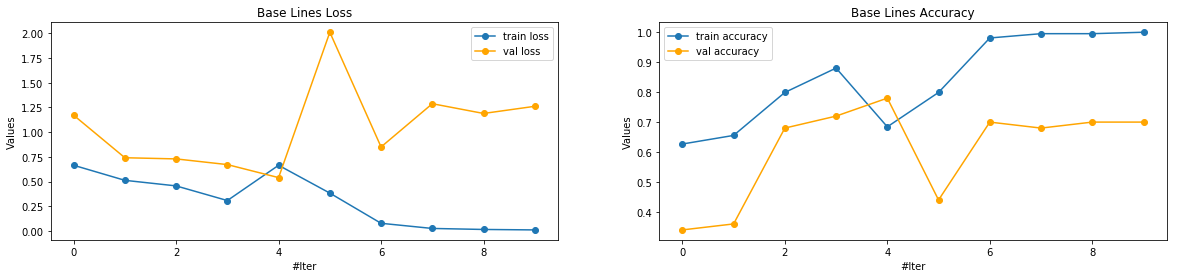

In [12]:
plot_plot(train_loss_BL,train_acc_BL,val_acc_BL,val_loss_BL,method="Base Lines")

可以看到整个模型validation data loss 逐步上升,模型处于过拟合的状态,要解决过拟合,我们需要使用Regularization和Dropout.

### L1 Regularization

In [13]:
K.clear_session()
model_l1 = Create_BL_and_Dropout_Model(data=train_x,labels=train_y,
                                    val_data=test_x,val_labels=test_y,
                                    lr=0.01,epochs=500,batch_size=64,mode="l1",lambd=0.0022)

In [14]:
train_loss_l1 = get_history(model_l1.history.history['loss'],50)
train_acc_l1 = get_history(model_l1.history.history['acc'],50)
val_loss_l1 = get_history(model_l1.history.history['val_loss'],50)
val_acc_l1 = get_history(model_l1.history.history['val_acc'],50)

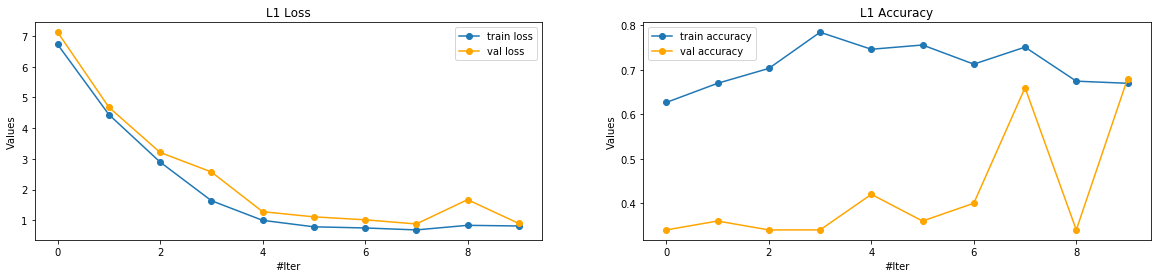

In [15]:
plot_plot(train_loss_l1,train_acc_l1,val_acc_l1,val_loss_l1,method="L1")

L1 很明显改善了BL的结果,且在9个epoch的时候能够达到当前最优.

### L2 Regularization

In [16]:
K.clear_session()
model_l2 = Create_BL_and_Dropout_Model(data=train_x,labels=train_y,
                                    val_data=test_x,val_labels=test_y,
                                    lr=0.01,epochs=500,batch_size=64,mode="l2",lambd=0.09)

In [17]:
train_loss_l2 = get_history(model_l2.history.history['loss'],50)
train_acc_l2 = get_history(model_l2.history.history['acc'],50)
val_loss_l2 = get_history(model_l2.history.history['val_loss'],50)
val_acc_l2 = get_history(model_l2.history.history['val_acc'],50)

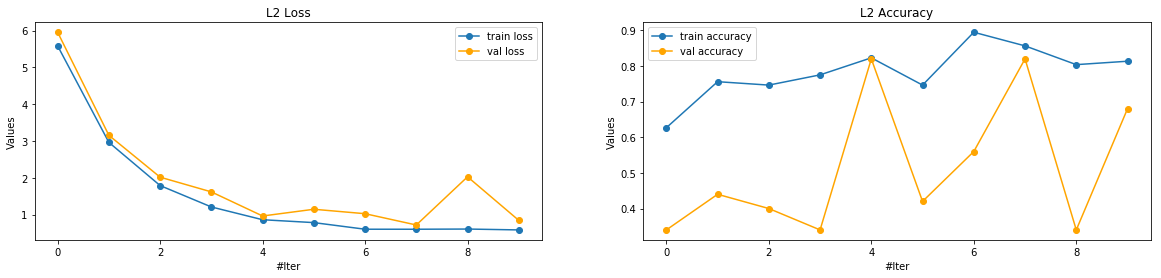

In [18]:
plot_plot(train_loss_l2,train_acc_l2,val_acc_l2,val_loss_l2,method="L2")

L2的效果就不如L1强劲,在当前模型下大约7个epoch的时候效果最好.但是validation波动太大,这里就不在尝试调节了.

### Dropout

In [19]:
K.clear_session()
model_dp = Create_BL_and_Dropout_Model(data=train_x,labels=train_y,
                                    val_data=test_x,val_labels=test_y,
                                    lr=0.01,epochs=500,batch_size=64,mode="DP",rate=0.35)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
train_loss_dp = get_history(model_dp.history.history['loss'],50)
train_acc_dp = get_history(model_dp.history.history['acc'],50)
val_loss_dp = get_history(model_dp.history.history['val_loss'],50)
val_acc_dp = get_history(model_dp.history.history['val_acc'],50)

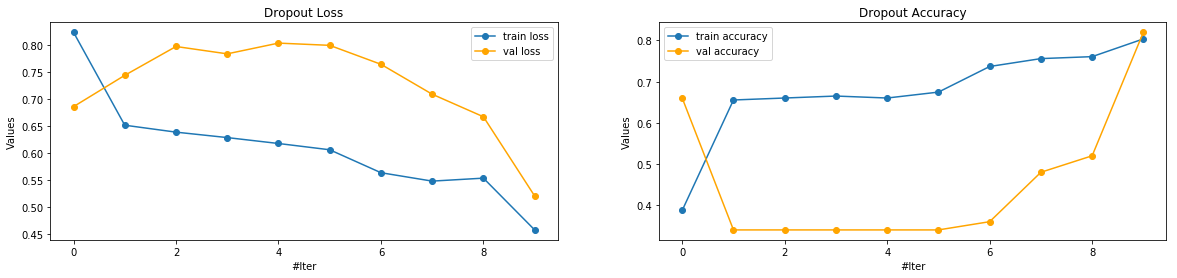

In [21]:
plot_plot(train_loss_dp,train_acc_dp,val_acc_dp,val_loss_dp,method="Dropout")

Dropout效果是比较好的,在当前模型下9个epochs的时候效果最好.

# Summary

(1) 其实初始化随机数对于模型的影响主要就是在调节模型阶段,我们需要确保结果的影响是来自于超级参数而不是初始化随机数的影响.在微调模型的时候会起到关键作用.

(2) 当然最好的方式还是多次运行模型寻求平均的一个结果才是最可信的,但是非常耗时.

(3) 对于解决过拟合,我们可以使用Regularization和Dropout,但是两者只是一个优化,并不意味着直接使用两者就能够将模型调节到"Best"的状态.